In [1]:
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline
from scipy.optimize import minimize_scalar
from tqdm import tqdm
import numpy as np
from main import (_make_design_matrix,
                  _make_penalty_matrix,
                  _compute_optimal_gcv_parameter,
                  _make_spline,
                 )

# Степенной базис (рис. 1)

In [2]:
np.random.seed(1234)
n = 200
g = lambda x: x**3 + x**2*np.sin(6 * x)
x = np.sort(np.random.random_sample(n) * 4 - 2)
y = g(x) + np.random.normal(scale=1, size=n)
eps = 0.1

In [3]:
X = np.array([[x_i**i for i in range(4)] for x_i in x], dtype=float)
c = np.linalg.inv(X.T @ X) @ X.T @ y
f = lambda x: sum([c[i] * x**i for i in range(4)])

T1 = 177.57


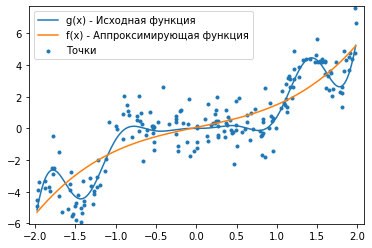

In [4]:
grid = np.linspace(x[0], x[-1], 1000)
plt.scatter(x, y, marker='.', label='Точки')
plt.plot(grid, g(grid), label='g(x) - Исходная функция')
plt.plot(grid, f(grid), label='f(x) - Аппроксимирующая функция')
plt.xlim(x[0] - eps, x[-1] + eps)
plt.ylim(min(y) - eps, max(y) + eps)
plt.legend(loc='best')
plt.savefig('Pictures/MNK_pow.png', dpi=500)
T1 = round(sum([(f(x[i]) - g(x[i]))**2 for i in range(n)]), 2)
print(f"T1 = {T1}")

# Базис Б-сплайнов (рис. 2)

In [5]:
t = np.linspace(x[0], x[-1], 38)
t = np.r_[[t[0]] * 3, t, [t[-1]] * 3]
X = BSpline.design_matrix(x, t, 3).toarray()
c = np.linalg.inv(X.T @ X) @ X.T @ y
f = BSpline(t, c, 3)

T2 = 43.66


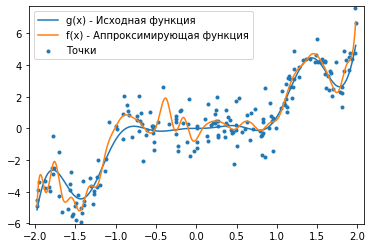

In [6]:
plt.scatter(x, y, marker='.', label='Точки')
plt.plot(grid, g(grid), label='g(x) - Исходная функция')
plt.plot(grid, f(grid), label='f(x) - Аппроксимирующая функция')
plt.xlim(x[0] - eps, x[-1] + eps)
plt.ylim(min(y) - eps, max(y) + eps)
plt.legend(loc='best')
plt.savefig('Pictures/MNK_bspl.png', dpi=500)
T2 = round(sum([(f(x[i]) - g(x[i]))**2 for i in range(n)]), 2)
print(f"T2 = {T2}")

# Графики при различных значениях $\lambda$ (рис. 3)

In [7]:
opt_lam = _compute_optimal_gcv_parameter(x, y)
spline = []
lam_list = [1e-8, 1., opt_lam]
for i in range(3):
    spline += [_make_spline(x, y, lam_list[i])]

T1 = 146.07
T2 = 122.18
T3 = 23.25


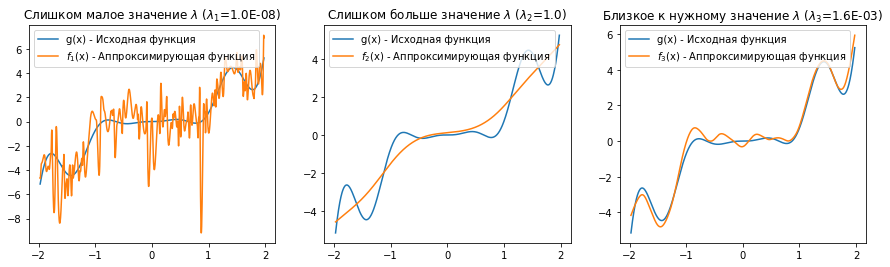

In [8]:
figure, axis = plt.subplots(1, 3, figsize=(15, 4))
tl = [fr'Слишком малое значение $\lambda$ ($\lambda_1$={lam_list[0]:.1E})',
      fr'Слишком больше значение $\lambda$ ($\lambda_2$={lam_list[1]})',
      fr'Близкое к нужному значение $\lambda$ ($\lambda_3$={(lam_list[2]):.1E})']
for i in range(3):
    axis[i].set_title(tl[i])
    axis[i].plot(grid, g(grid), label='g(x) - Исходная функция')
    axis[i].plot(grid, spline[i](grid), label=f'$f_{i + 1}$(x) - Аппроксимирующая функция')
    axis[i].legend(loc='upper left')
figure.savefig('Pictures/DifferentLam.png')
for j in range(3):
    T_j = round(sum([(spline[j](x[i]) - g(x[i]))**2 for i in range(n)]), 2)
    print(f'T{j + 1} = {T_j}')

# График критериев (рис. 4)

In [9]:
np.random.seed(1234)

sc = .1

n = 50
g = lambda x: x**3 + x**2*np.sin(6 * x)
x = np.sort(np.random.random_sample(n) * 4 - 2)
t = np.r_[[x[0]]*3, x, [x[-1]]*3]
y = g(x) + np.random.normal(scale=sc, size=n)

X = _make_design_matrix(x)
E = _make_penalty_matrix(x)

def _make_full_matrix(H, n):
    H_full = np.zeros((n, n), dtype=float)
    H_full[2:, :-2][np.diag_indices(n - 2)] = H[4, :-2]
    H_full[1:, :-1][np.diag_indices(n - 1)] = H[3, :-1]
    H_full[np.diag_indices(n)] = H[2]
    H_full[:-1, 1:][np.diag_indices(n - 1)] = H[1, 1:]
    H_full[:-2, 2:][np.diag_indices(n - 2)] = H[0, 2:]
    return H_full

X_full = _make_full_matrix(X, n)
E_full = _make_full_matrix(E, n)

In [10]:
def CV(lam, X, P, n):
    A = X @ np.linalg.inv(X + lam * P)
    B = np.diag(1. / (1. - np.diag(A)))
    return np.linalg.norm(B @ (np.eye(n) - A) @ y)**2 / n

def GCV(lam, X, P, n):
    A = X @ np.linalg.inv(X + lam * P)
    num = np.linalg.norm((np.eye(n) - A) @ y)**2
    den = np.linalg.norm(np.trace(np.eye(n) - A) / n)**2
    return num / (den * n)

def TrueMeanSq(lam, x, y, n, func):
    if lam < 0:
        return 10.
    spl = _make_spline(x, y, lam)
    return np.linalg.norm(spl(x) - func(x))**2 / n

CV_l = lambda lam: CV(lam, X_full, E_full, n)
GCV_l = lambda lam: GCV(lam, X_full, E_full, n)
T = lambda lam: TrueMeanSq(lam, x, y, n, g)

In [11]:
CV_min = minimize_scalar(CV_l, bracket=(1e-10,2.),
                        method='Golden', tol=1e-15,
                        options={'maxiter': 500})
GCV_min = minimize_scalar(GCV_l, bracket=(1e-10,2.),
                        method='Golden', tol=1e-15,
                        options={'maxiter': 500})
T_min = minimize_scalar(T, bracket=(1e-10,2.),
                        method='Golden', tol=1e-15,
                        options={'maxiter': 500})

In [12]:
print(f"CV : {CV_min.success} --- {CV_min.nit} --- lam = {CV_min.x:.3}")
print(f"GCV: {GCV_min.success} --- {GCV_min.nit} --- lam = {GCV_min.x:.3}")
print(f"T  : {T_min.success} --- {T_min.nit} --- lam = {T_min.x:.3}")

CV : True --- 101 --- lam = 3.23e-06
GCV: True --- 94 --- lam = 7.63e-05
T  : True --- 95 --- lam = 5.52e-05


In [13]:
mean_x = np.mean([CV_min.x, GCV_min.x, T_min.x])
grid = np.linspace(np.log(mean_x) - 10, np.log(mean_x) + 10, 100)
grid = np.exp(grid)

CV_arr = []
GCV_arr = []
T_arr = []
for elem in tqdm(grid):
    CV_arr += [CV_l(elem)]
    GCV_arr += [GCV_l(elem)]
    T_arr += [T(elem)]

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 64.56it/s]


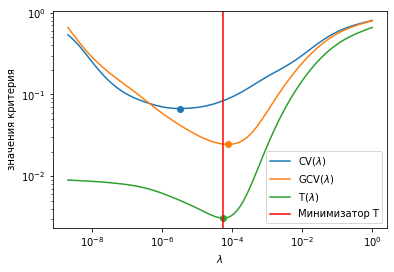

In [14]:
plt.plot(grid, CV_arr, label='CV($\lambda$)')
plt.plot(grid, GCV_arr, label='GCV($\lambda$)')
plt.plot(grid, T_arr, label='T($\lambda$)')
plt.scatter(CV_min.x, CV_min.fun)
plt.scatter(GCV_min.x, GCV_min.fun)
plt.axvline(T_min.x, color='red', label='Минимизатор T')
plt.scatter(T_min.x, T_min.fun)
plt.loglog()
plt.legend(loc='best')
plt.xlabel("$\lambda$")
plt.ylabel("значения критерия")
plt.savefig('Pictures/CVGCV.png', dpi=500)
plt.show()

In [15]:
print(f'GCV = {T(GCV_min.x) / T_min.fun}')
print(f'CV  = {T(CV_min.x) / T_min.fun}')

GCV = 1.0230496410470529
CV  = 1.6444161094021534


# График сплайн-функций (рис. 5)

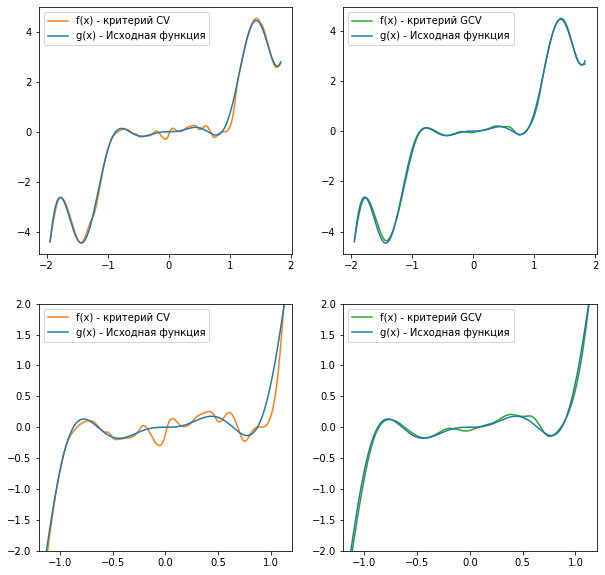

In [16]:
x_bounds = (-1.2, 1.2)
y_bounds = (-2, 2)
figure, axis = plt.subplots(2, 2, figsize=(10, 10))

spl_cv = _make_spline(x, y, CV_min.x)
spl_gcv = _make_spline(x, y, GCV_min.x)
spl_t = _make_spline(x, y, T_min.x)

grid = np.linspace(x[0], x[-1], 1000)

axis[0, 0].plot(grid, spl_cv(grid), label='f(x) - критерий CV', c='C1')
axis[0, 1].plot(grid, spl_gcv(grid), label='f(x) - критерий GCV', c='C2')
for i in range(2):
    axis[0, i].plot(grid, g(grid), label='g(x) - Исходная функция', c='C0')
    axis[0, i].legend(loc='best')
axis[1, 0].plot(grid, spl_cv(grid), label='f(x) - критерий CV', c='C1')
axis[1, 1].plot(grid, spl_gcv(grid), label='f(x) - критерий GCV', c='C2')
for i in range(2):
    axis[1, i].plot(grid, g(grid), label='g(x) - Исходная функция', c='C0')
    axis[1, i].set_xlim(x_bounds)
    axis[1, i].set_ylim(y_bounds)
    axis[1, i].legend(loc='best')
figure.savefig('Pictures/graphs.png', dpi=500)